In [1]:
%matplotlib inline
import sys
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.ext.composition_methods import *
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.couple import bridge
# from amuse.community.huayno.interface import Huayno

In [2]:
def ProgressBar(total, progress):
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# def relative_orbital_velocity(distance, mass=SMBH.mass):
#     return (constants.G*mass/distance).sqrt()

def plot():
    plt.figure(figsize=(8,6))
    scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='blue', label='BH')
    scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
    plt.annotate(str(round(model_time.value_in(units.Myr)))+" Myr", xy=(6.9, 9), xytext=(6.9, 9), 
                 weight='heavy', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.5))
    #plt.title("Evolved to t = "+str(round(model_time.value_in(units.Myr)))+" Myr")
    plt.axis('square')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two BHs", particles_in_encounter.name, particles_in_encounter.mass.in_(units.MSun),
          "collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G=constants.G):
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    
    average_Ek = 1.70 | units.km**2/units.s**2
    
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                com_pos = binary.center_of_mass()
                binary_momentum = binary.velocity * binary.mass.reshape((-1,1))
                L_b = (binary.position-com_pos).cross(binary_momentum).sum(axis=0)
                L_b = L_b.in_(units.pc*units.MSun*units.km/units.s)
                binary.thetaz = L_b[2] / L_b.length() # angle between the angular momentum and z-axis
                binaries.append(binary)
            j+=1  

    return binaries, average_Ek


def get_hardness(BBH, particles, G=constants.G):
    
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    
    r2=(BBH.x[0]-BBH.x[1])**2+ \
       (BBH.y[0]-BBH.y[1])**2+ \
       (BBH.z[0]-BBH.z[1])**2 
    v2=(BBH.vx[0]-BBH.vx[1])**2+ \
       (BBH.vy[0]-BBH.vy[1])**2+ \
       (BBH.vz[0]-BBH.vz[1])**2 
    r=r2**0.5
    eb=G*(BBH.mass[0]+BBH.mass[1])/r-0.5*v2
    average_Ek = 1.70 | (units.km**2/units.s**2)
    hardness = eb/average_Ek
    
    return hardness

def relative(property1, property2):
    return ((property1 - property2)**2).sum()**0.5

## Initial condition

In [4]:
# Start with Sgr A*
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2
SMBH0 = SMBH.copy()

r = 10 # (pc) The outmost orbital radius of BHs surrounding the SMBH

# Make BH disk
def make_BHdisk_around_SMBH(SMBH=SMBH0, n_BH=1000, Mmin=1.0, Mmax=100.0):
    R = r|units.pc
    Ndisk = n_BH
    Rin = 0.1
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, Mmin|units.MSun, Mmax|units.MSun, -2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BH+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    for i in range(n_BH):
        BHdisk[i].name = "BH"+BHdisk[i].name
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH=SMBH0, Mdisk=1e-3, Ndisk=1000, rho=3.0):
    R = r|units.pc
    Ndisk = Ndisk
    Rin = 0.1
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = Mdisk * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
#     gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = rho | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

In [5]:
# The initial distribution of our objects
# plot()
# scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
# plt.xlabel("x [pc]")
# plt.ylabel("y [pc]")
# plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
# plt.show()

## BBH setup

In [6]:
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

N_BBH = 20
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH0, 200)

BBH0 = Particles(0)
n = 0

for i in range(1, 201):
    print(n,"/",i)
    if n >= N_BBH:
        break
    BBH_test = BBH0.copy()
    
    while True:
        flag = 1
        
        BBHi_1mass, BBHi_2mass = new_powerlaw_mass_distribution(2, 1.0|units.MSun, 
                                                          100.0|units.MSun, -2.35)
        np.random.seed()
        a = (np.random.rand(1)[0]*500+500) | units.au
        np.random.seed()
        e = np.random.rand(1)[0]/2
        BBHi = new_binary_from_orbital_elements(BBHi_1mass, BBHi_2mass, 
                                              a, e, G=constants.G)
        setattr(BBHi, "name", [f"BBH{n+1:d}_1", f"BBH{n+1:d}_2"])

        BBHi.position += BHdisk[BHdisk.name==f'BH{i:d}'].position
        
        if len(BBH0)>0: # avoid BBHs coming too close
            for j in range(0, len(BBH0)):
                if abs(relative(BBHi.center_of_mass(), SMBH0.position).value_in(units.pc)-
                       relative(BBH0[j].position, SMBH0.position).value_in(units.pc))<0.2:
                    flag = 0
                    break 
        if flag==0:
            break
        
        BBHi.velocity += BHdisk[BHdisk.name==f'BH{i:d}'].velocity
        
        BBHi.radius = 2*constants.G*BBHi.mass/constants.c**2

        BBH_test.add_particles(BBHi)
#         BBH_test = BBH_test[BBH_test.name!=f'BH{i:d}']
        hardness = get_hardness(BBHi, BBH_test)
        
#         print(f'Hardness of current BBH{i:d} = {hardness:.2f}.')

        if (hardness>=5) & (hardness<9): # constraint the hardness of BBH initial condition
            BBH0 = BBH_test.copy()
            n += 1
            break
        else:
            BBH_test = BBH0.copy()
            
# BBH0 = bodies[n_BH-N_BBH+1:].copy()
print("Soft BBH number is", int(len(BBH0)/2))

0 / 1
1 / 2
2 / 3
3 / 4
4 / 5
5 / 6
6 / 7
7 / 8
8 / 9
8 / 10
8 / 11
8 / 12
9 / 13
9 / 14
10 / 15
11 / 16
12 / 17
12 / 18
13 / 19
13 / 20
13 / 21
13 / 22
14 / 23
15 / 24
15 / 25
15 / 26
16 / 27
16 / 28
17 / 29
17 / 30
18 / 31
19 / 32
19 / 33
19 / 34
20 / 35
Soft BBH number is 20


## Reference Simulation (only initial BBHs, no BH disk)

In [7]:
SMBH_ref = SMBH0.copy()
BBH_ref = BBH0.copy()
bodies_ref = Particles(0)
bodies_ref.add_particles(SMBH_ref)
bodies_ref.add_particles(BBH_ref)

BBH_ref = bodies_ref[1:]
SMBH_ref = bodies_ref[0]

In [8]:
gravity = ph4(converter1, number_of_workers=32)
gravity.particles.add_particles(bodies_ref)
channel = gravity.particles.new_channel_to(bodies_ref)

# fig_root = "figure/Ref/"

In [9]:
# Stopping condition of collision 
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

bodies_ref.radius *= collision_radius_multiplication_factor

# Evolving parameters
end_time = 10 | units.Myr
model_time = 0 | units.Myr
dt = 1e-2 | units.Myr
x = 0

BBH_ref_info = []
# aE_ref_info = []
# SMBH_ref_info = []
# Evolve
while(model_time<end_time):
    
    ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))
    
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, bodies_ref) # Collisions detection
    channel.copy()
    
    if model_time.value_in(units.Myr)>=x:
        x += 0.5
        
        BBH_ref_info_time = []
        for i in range(N_BBH):
            name1, name2 = BBH_ref[i*2:i*2+2].name
            mass1, mass2 = BBH_ref[i*2:i*2+2].mass.value_in(units.MSun)
            a = BBH_ref[i*2].position - BBH_ref[i*+2+1].position
            hardness = get_hardness(BBH_ref[i*2:i*2+2], bodies_ref)
            a = relative(BBH_ref[i*2].position, BBH_ref[i*2+1].position).value_in(units.au)
            r = relative(BBH_ref[i*2:i*2+2].center_of_mass(), bodies_ref.center_of_mass()).value_in(units.pc)
            v1_v2 = relative(BBH_ref[i*2].velocity, BBH_ref[i*2+1].velocity).value_in(units.km/units.s)
            
            BBH_ref_info_time.append([model_time.value_in(units.Myr), 
                                  name1, name2, mass1, mass2, hardness, a, r, v1_v2])
        
        BBH_ref_info.append(BBH_ref_info_time)
        
#         total_Ek=(0.5*bodies_ref.mass*(bodies_ref.vx**2+bodies_ref.vy**2+bodies_ref.vz**2)).sum()
#         average_Ek=total_Ek/bodies_ref.mass.sum()
#         aE_ref_info.append([model_time.value_in(units.Myr), average_Ek.value_in(units.km**2*units.s**(-2))])
#         SMBH_ref_info.append([# time
#                             model_time.value_in(units.Myr), 
#                             # BBH orbital velocity
#                             relative(SMBH_ref.velocity, bodies_ref.center_of_mass_velocity()).value_in(units.kms),
#                             # SMBH + BBH mass center energy (excluding binary intrinsic energy)
#                             0.5*sum(SMBH_ref.velocity.value_in(units.kms)**2)*SMBH_ref.mass.value_in(units.MSun)+0.5*sum(BBH_ref.center_of_mass_velocity().value_in(units.km/units.s)**2)*BBH_ref.total_mass().value_in(units.MSun)-(constants.G*(SMBH_ref.mass*BBH_ref.total_mass())/(r)).value_in(units.MSun*units.kms**2*units.pc)])
        
    model_time += dt

gravity.stop()
BBH_ref_info = np.array(BBH_ref_info)

[####################] 100% 

### Analysis of the reference simulation 

0


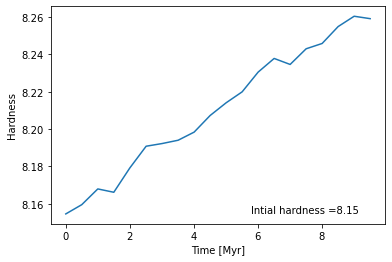

1


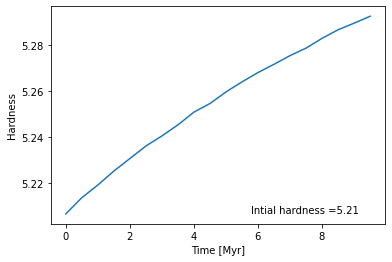

2


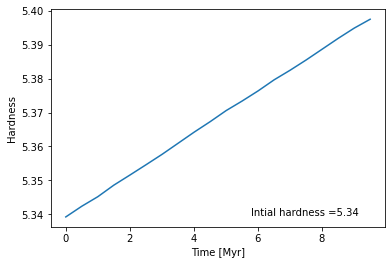

3


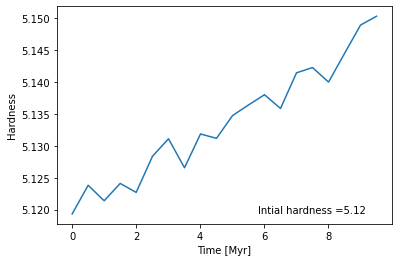

4


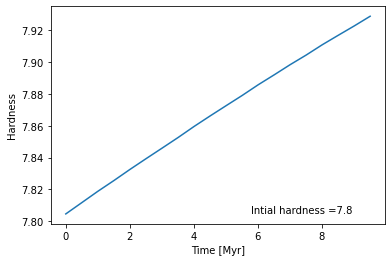

5


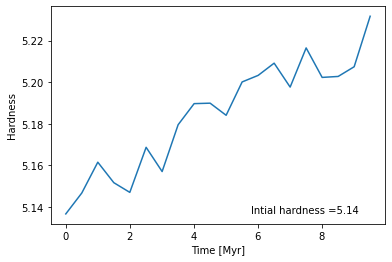

6


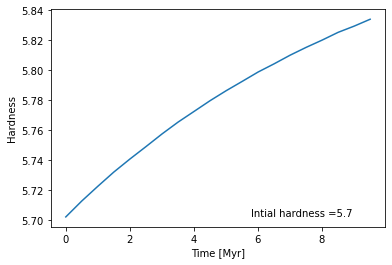

7


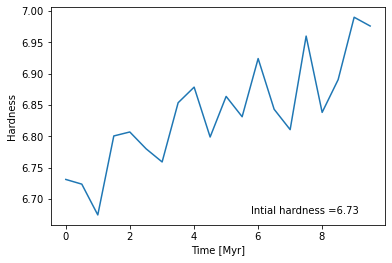

8


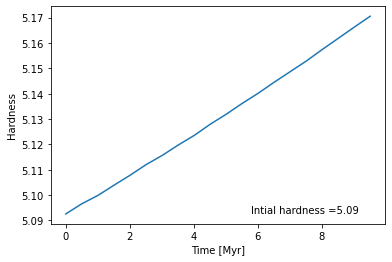

9


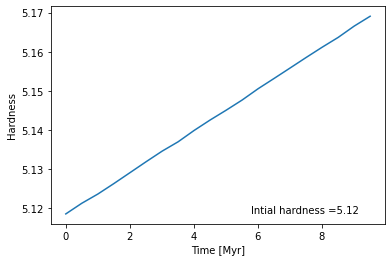

10


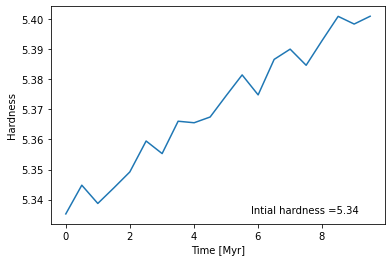

11


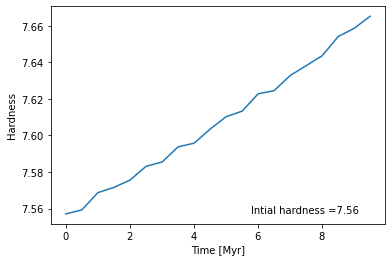

12


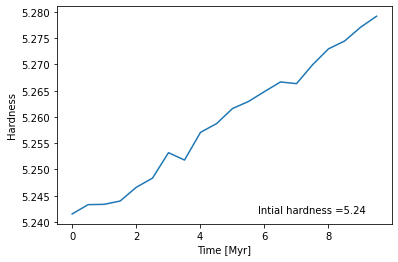

13


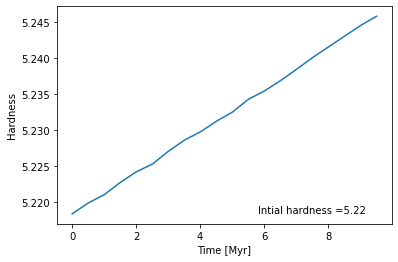

14


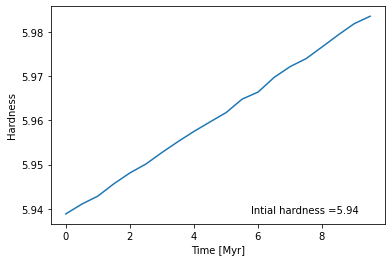

15


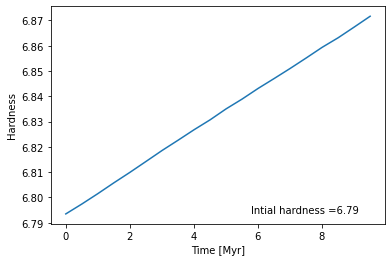

16


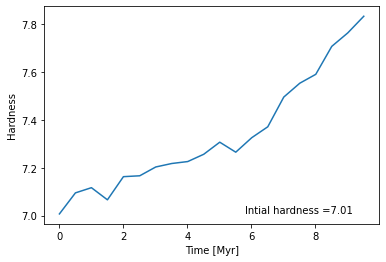

17


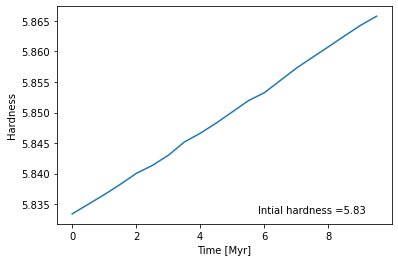

18


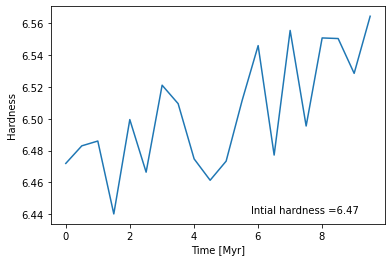

19


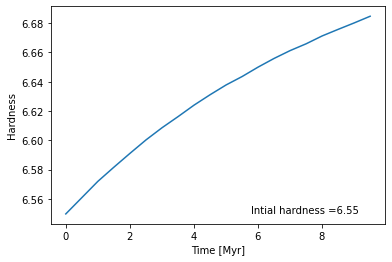

In [10]:
for i in range(N_BBH):
    print(i)
    plt.figure()
    plt.plot(BBH_ref_info[:,i,0].astype('float'), BBH_ref_info[:,i,5].astype('float'))
    plt.annotate(f'Intial hardness ='+str(round(BBH_ref_info[:,i,5].astype('float')[0],2)), xy=(0.6,0.05), xycoords='axes fraction')
    plt.xlabel('Time [Myr]')
    plt.ylabel('Hardness')
    plt.show()

## Nbody simulation

In [11]:
def grav(n_BH=1000, Mmin=1.0, Mmax=100.0):
    print("Running Nbody (n_BH="+str(n_BH)+", Mmin="+str(round(Mmin,2))+"Msun, Mmax="+str(round(Mmax,2))+"Msun)......")

    BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH0, n_BH, Mmin, Mmax)

    bodies = Particles(0)
    bodies.add_particles(SMBH0)
    bodies.add_particles(BHdisk)
    bodies.add_particles(BBH0)
    # print(get_binaries(bodies)[1].value_in(units.km**2/units.s**2))

    SMBH = bodies[bodies.name=="SMBH"][0]
    BHdisk = bodies[1:n_BH+1]
    BBH  = bodies[n_BH+1:]
    
    gravity = ph4(converter1, number_of_workers=32)
    gravity.particles.add_particles(bodies)
    channel = gravity.particles.new_channel_to(bodies)

#     fig_root = "figure/Nbody/"


    # Stopping condition of collision 
    stopping_condition = gravity.stopping_conditions.collision_detection
    stopping_condition.enable()
    collision_radius_multiplication_factor = 1e5

    bodies.radius *= collision_radius_multiplication_factor

    # Evolving parameters
    end_time = 10 | units.Myr
    model_time = 0 | units.Myr
    dt = 1e-2 | units.Myr
    x = 0

    BBH_info = []

    # bodies_x = []
    # bodies_y = []

    # Evolve
    while(model_time<end_time):

        ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))

        gravity.evolve_model(model_time)
        resolve_collision(stopping_condition, gravity, bodies) # Collisions detection
        channel.copy()

    #     bodies_x.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    #     bodies_y.append(bodies.y.value_in(units.pc))

        if model_time.value_in(units.Myr)>=x:
            x += 0.5

            BBH_info_time = []
            for i in range(N_BBH):
                name1, name2 = BBH[i*2:i*2+2].name
                mass1, mass2 = BBH[i*2:i*2+2].mass.value_in(units.MSun)
                a = BBH[i*2].position - BBH[i*+2+1].position
                hardness = get_hardness(BBH[i*2:i*2+2], bodies)
                a = relative(BBH[i*2].position, BBH[i*2+1].position).value_in(units.au)
                r = relative(BBH[i*2:i*2+2].center_of_mass(), SMBH.position).value_in(units.pc)
                v1_v2 = relative(BBH[i*2].velocity, BBH[i*2+1].velocity).value_in(units.km/units.s)

                BBH_info_time.append([model_time.value_in(units.Myr), 
                                      name1, name2, mass1, mass2, hardness, a, r, v1_v2])

            BBH_info.append(BBH_info_time)

        model_time += dt
        
    gravity.stop()
    return np.array(BBH_info)

In [ ]:
n_BH = 1000 # Number of stellar-mass BHs
Mmin = 1
Mmax = 100

BBH_nbody = []

In [17]:
for i in range(9, 10):
    print(f"\nNbody trial {i:d}:")
    BBH_info = grav(n_BH=n_BH, Mmin=Mmin, Mmax=Mmax)

    BBH_nbody.append(BBH_info)



Nbody trial 9:
Running Nbody (n_BH=1000, Mmin=1Msun, Mmax=100Msun)......
[####################] 100% 

In [78]:
print(len(BBH_nbody))

10


## Bridge Nbody and Hydro

In [19]:
def gravhydro(Mdisk=1e-3, Ndisk=1000, rho=3.0):
    
    print("Running Bridge (Mdisk="+str(round(Mdisk,5))+"Msmbh, rho="+str(round(rho,2))+"g/cm3, Ndisk="+str(Ndisk)+")......")
    
    bodies = Particles(0)
    bodies.add_particles(SMBH0)
    bodies.add_particles(BBH0)

    SMBH = bodies[bodies.name=="SMBH"]
    BBH = bodies[bodies.name!="SMBH"]
    BBH = BBH[BBH.name!="gas disk"]

    Nbody = SMBH+BBH

    gravityA = ph4(converter1, number_of_workers=32)
    gravityA.particles.add_particles(Nbody)
    channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
                "to_BHs": gravityA.particles.new_channel_to(bodies)}
    
    gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH0, Mdisk=Mdisk, Ndisk=Ndisk, rho=rho)

    hydro = Fi(converter2, mode="openmp", workers=32)
    hydro.parameters.use_hydro_flag = True
    hydro.parameters.radiation_flag = False
    hydro.parameters.gamma = 1
    hydro.parameters.isothermal_flag = True
    hydro.parameters.integrate_entropy_flag = False
    hydro.parameters.timestep = 5e2 | units.yr
    hydro.parameters.verbosity = 0
    hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
    eps = 10 | units.au
    hydro.parameters.gas_epsilon = eps
    hydro.parameters.sph_h_const = eps
    
    bodies.add_particles(gasdisk)
    gasdisk = bodies[bodies.name=="gas disk"]

    hydro.particles.add_particles(gasdisk)
    # hydro.dm_particles.add_particles(SMBH.as_set())
    channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
    channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
    # channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
    # channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

#     fig_root = "figure_disk/"
#     fig_root1 = fig_root+"Mdisk="+str(Mdisk)+"_rho="+str(rho)+"_Ndisk="+str(Ndisk)+"/"
    
#     if os.path.exists(fig_root1)==False:
#         os.mkdir(fig_root1)
    
    # Bridge gravity and hydro
    gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
    gravhydro.add_system(gravityA, (hydro,))
    gravhydro.add_system(hydro, (gravityA,))

    # Stopping condition of collision 
    stopping_condition = gravityA.stopping_conditions.collision_detection
    stopping_condition.enable()
    collision_radius_multiplication_factor = 1e5

    Nbody.radius *= collision_radius_multiplication_factor

    # Bridge timestep
    gravhydro.timestep = 5e3 | units.yr

#     binary_b = []

    model_time = 0 | units.Myr
    end_time = 10 | units.Myr
    dt = 1e-2 | units.Myr
    x = 0
    
    BBH_hg_info = []

    gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()

    while model_time < end_time:    

        ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))
        gravhydro.evolve_model(model_time)
        resolve_collision(stopping_condition, gravityA, Nbody) # Collision detection

        channel["to_BHs"].copy()
        channel["to_gasdisk"].copy()

    #     bodies_x_b.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    #     bodies_y_b.append(bodies.y.value_in(units.pc))

        if model_time.value_in(units.Myr)>=x:
            x+=0.5

            BBH_hg_info_time = []
            for i in range(N_BBH):
                name1, name2 = BBH[i*2:i*2+2].name
                mass1, mass2 = BBH[i*2:i*2+2].mass.value_in(units.MSun)
                a = BBH[i*2].position - BBH[i*+2+1].position
                hardness = get_hardness(BBH[i*2:i*2+2], Nbody)
                a = relative(BBH[i*2].position, BBH[i*2+1].position).value_in(units.au)
                r = relative(BBH[i*2:i*2+2].center_of_mass(), SMBH.position).value_in(units.pc)
                v1_v2 = relative(BBH[i*2].velocity, BBH[i*2+1].velocity).value_in(units.km/units.s)

                BBH_hg_info_time.append([model_time.value_in(units.Myr), 
                                      name1, name2, mass1, mass2, hardness, a, r, v1_v2])

            BBH_hg_info.append(BBH_hg_info_time)

        model_time += dt

    gravityA.stop()
    hydro.stop()
    
    return np.array(BBH_hg_info)

In [20]:
Mdisk = 1e-3
Ndisk = 1000
rho = 3.0

BBH_bridge = []

In [35]:
for i in range(0, 10):
    print(f"Bridge trial {i:d}:")
    BBH_hg_info = gravhydro(Mdisk=Mdisk, Ndisk=Ndisk, rho=rho)
    BBH_bridge.append(BBH_hg_info)


Bridge trial 0:
Running Bridge (Mdisk=0.001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 

In [38]:
print(len(BBH_bridge))

10


In [72]:
Mdisk = 0.1e-3
Ndisk = 1000
rho = 3.0

BBH_bridge_m01 = []

In [73]:
for i in range(0, 10):
    print(f"\nBridge trial {i:d}:")
    BBH_hg_info = gravhydro(Mdisk=Mdisk, Ndisk=Ndisk, rho=rho)
    BBH_bridge_m01.append(BBH_hg_info)



Bridge trial 0:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 1:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 2:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 3:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 4:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 5:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 6:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 7:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[####################] 100% 
Bridge trial 8:
Running Bridge (Mdisk=0.0001Msmbh, rho=3.0g/cm3, Ndisk=1000)......
[###################

In [74]:
print(len(BBH_bridge_m01))

10


### Analysis of the Nbody simulation 

0


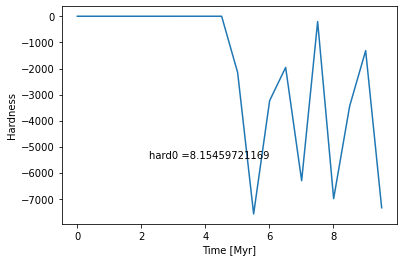

1


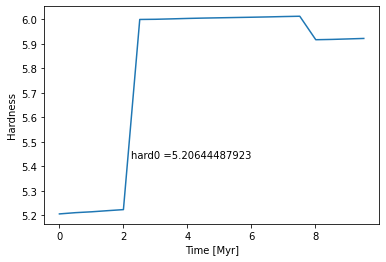

2


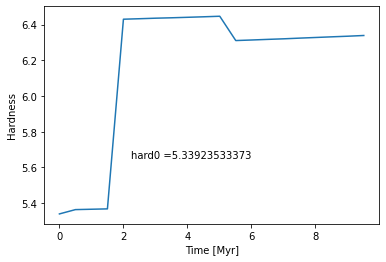

3


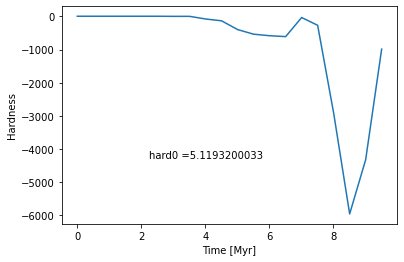

4


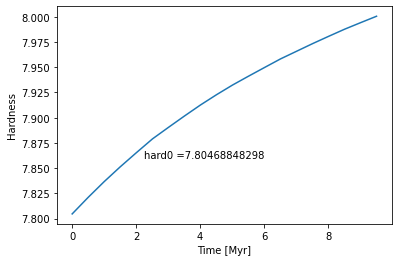

5


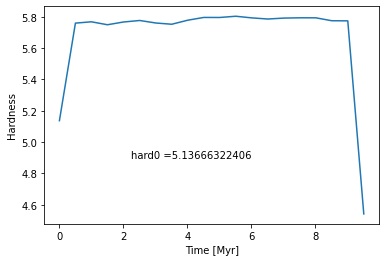

6


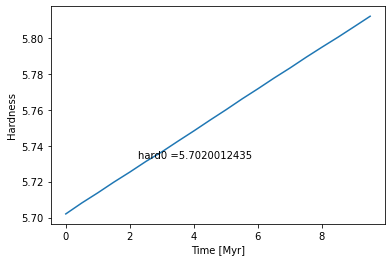

7


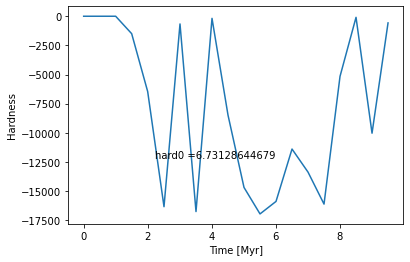

8


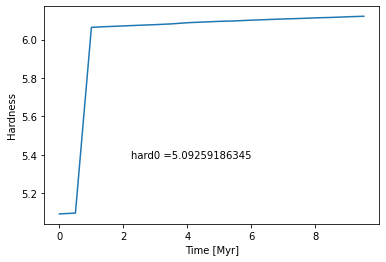

9


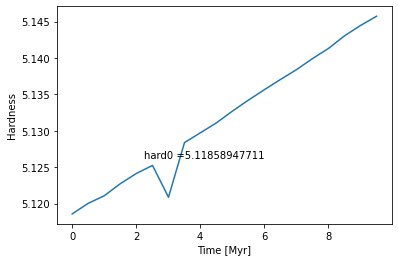

10


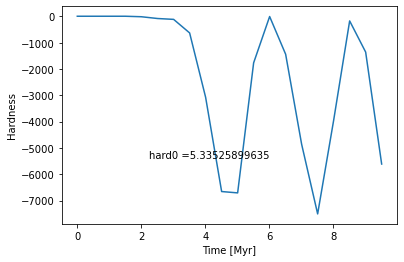

11


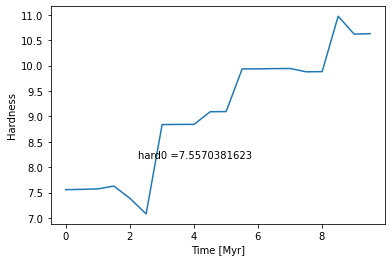

12


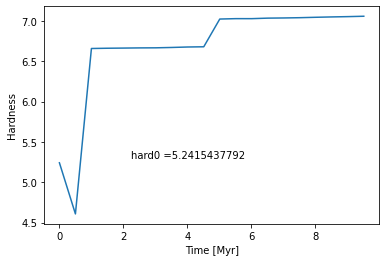

13


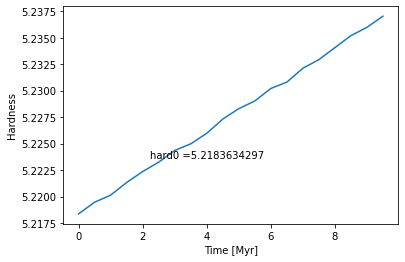

14


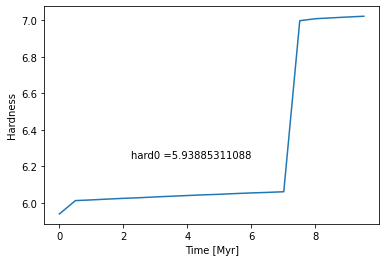

15


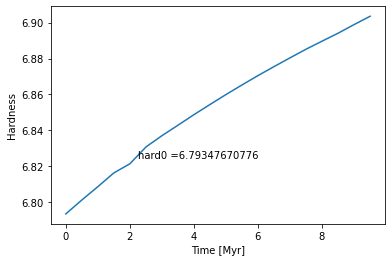

16


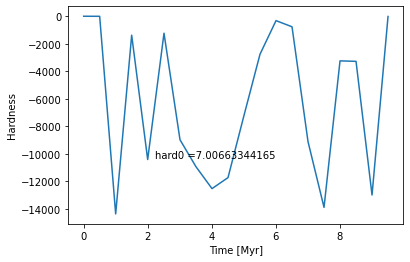

17


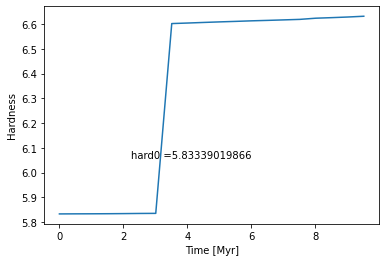

18


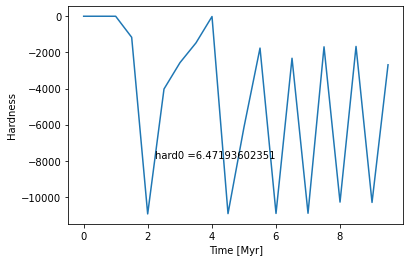

19


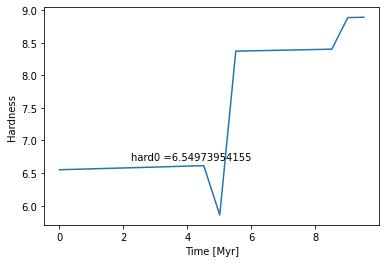

In [41]:
for i in range(N_BBH):
    print(i)
    plt.figure()
    plt.plot(np.array(BBH_nbody)[0,:,i,0].astype('float'), np.array(BBH_nbody)[0,:,i,5].astype('float'))
    plt.annotate(f'hard0 ='+str(np.array(BBH_nbody)[0,:,i,5].astype('float')[0]), xy=(0.26,0.3), xycoords='axes fraction')
    plt.xlabel('Time [Myr]')
    plt.ylabel('Hardness')
    plt.show()

### Analysis of the bridge simulation

Exception ignored in: <function CodeInterface.__del__ at 0x7fa5869a7380>
Traceback (most recent call last):
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 755, in __del__
    self._stop()
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 845, in _stop
    self._stop_worker()
  File "/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/rfi/core.py", line 123, in __call__
    raise exceptions.CodeException("Exception when calling function '{0}', of code '{1}', exception was '{2}'".format(self.specification.name, type(self.interface).__name__, ex))
amuse.support.exceptions.CodeException: Exception when calling function '_stop_worker', of code 'ph4Interface', exception was '[Errno 9] Bad file descriptor'


0


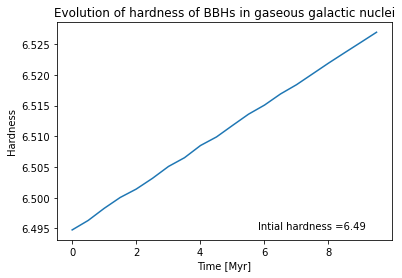

1


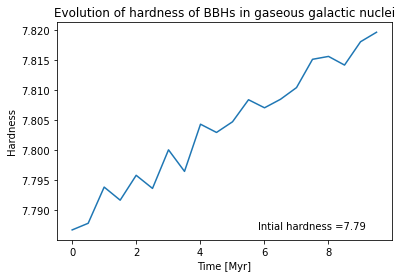

2


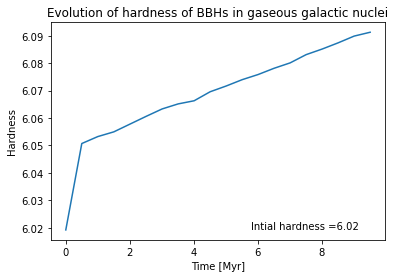

3


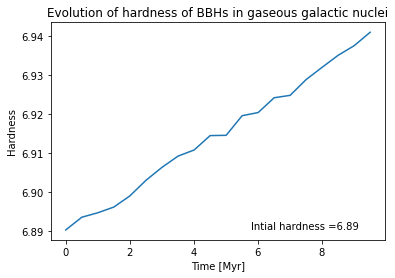

4


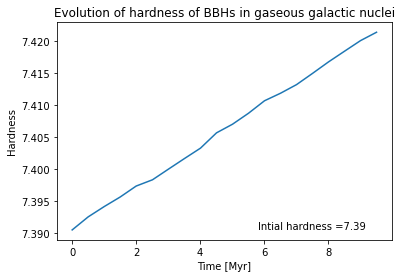

5


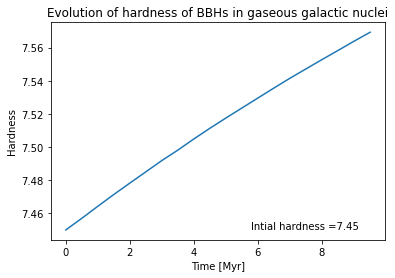

6


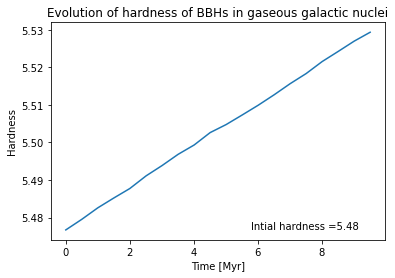

7


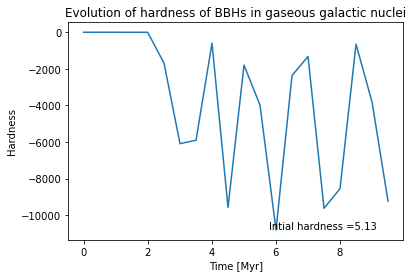

8


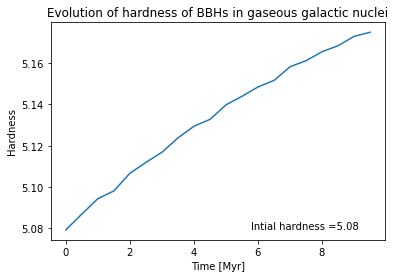

9


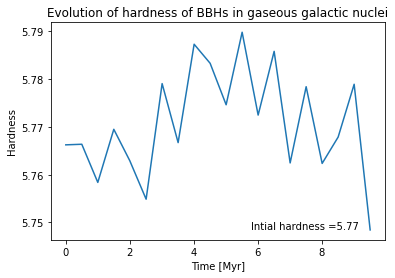

10


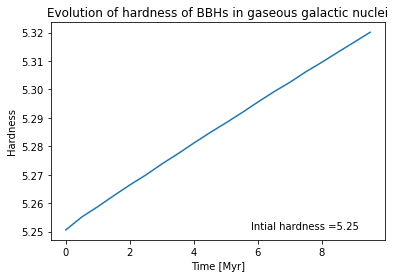

11


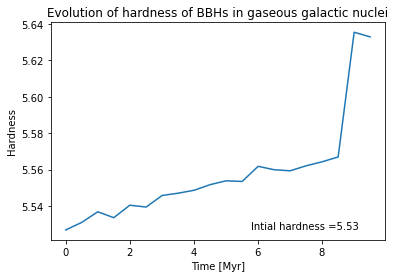

12


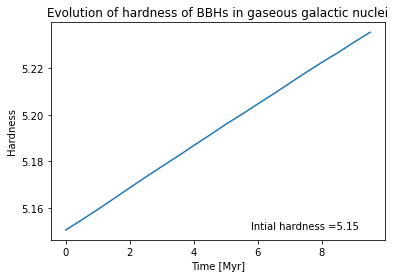

13


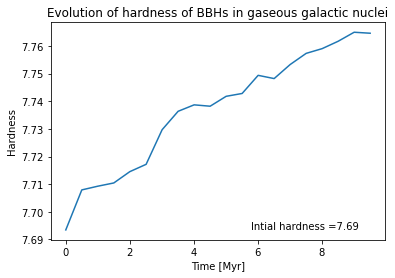

14


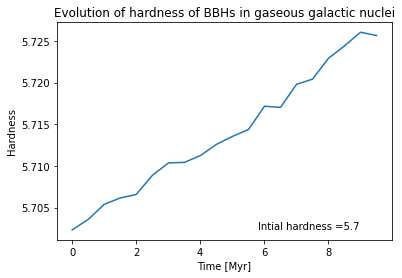

15


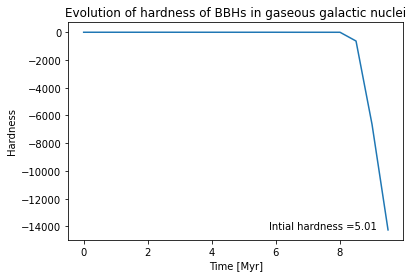

16


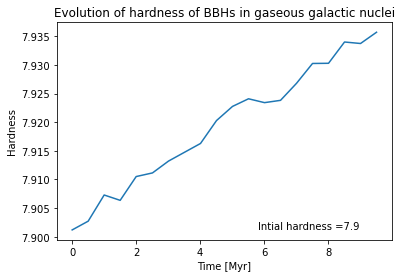

17


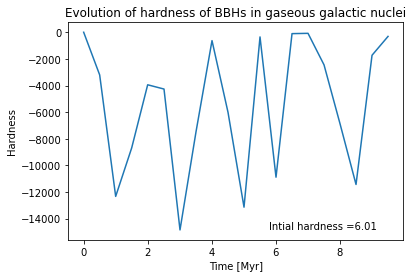

18


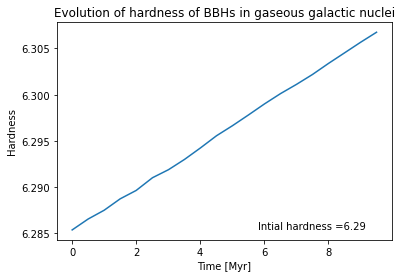

19


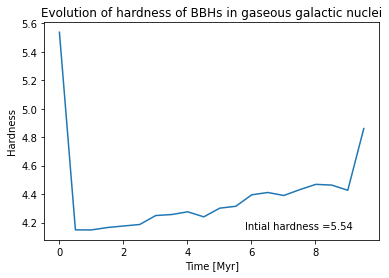

In [21]:
for i in range(N_BBH):
    print(i)
    plt.figure()
    plt.plot(BBH_hg_info[:,i,0].astype('float'), BBH_hg_info[:,i,5].astype('float'))
    plt.annotate(f'Intial hardness ='+str(round(BBH_hg_info[:,i,5].astype('float')[0],2)), xy=(0.6,0.05), xycoords='axes fraction')
    plt.xlabel('Time [Myr]')
    plt.ylabel('Hardness')
    plt.title("Evolution of hardness of BBHs in gaseous galactic nuclei")
    plt.show()

## Analysis

In [37]:
np.save("BBH_nbody", np.array(BBH_nbody))
np.save("BBH_bridge", np.array(BBH_bridge))

In [22]:
BBH_init = []
for i in range(len(BBH0)):
    BBH_init.append([BBH0.mass[i].value_in(units.MSun), BBH0.name[i], BBH0.radius[i].value_in(units.m),
                   BBH0.vx[i].value_in(units.kms),BBH0.vy[i].value_in(units.kms),BBH0.vz[i].value_in(units.kms),
                   BBH0.x[i].value_in(units.pc),BBH0.y[i].value_in(units.pc),BBH0.z[i].value_in(units.pc)])
    
BBH_init = np.array(BBH_init)
np.savetxt("BBH_init.txt", BBH_init, fmt='%s', delimiter=',')

import os
with open('BBH_init.txt', 'r+') as f:
 content = f.read()  
 f.seek(0, 0)
 f.write('#mass/MSun,name,radius/m,vx/kms,vy/kms,vz/kms,x/pc,y/pc,z/pc\n'+content)

In [75]:
harder_BBH_nbody = 0
softer_BBH_nbody = 0
not_BBH_nbody = 0
much_harder_BBH_nbody = 0

for i in range(10):
    for j in range(N_BBH):
        hardness = np.array(BBH_nbody)[i,:,j,5].astype('float')
        d_hardness = hardness - BBH_ref_info[:,j,5].astype('float')
        if hardness[-1] < 0:
            not_BBH_nbody += 1
        elif d_hardness[-1] < 0:
            softer_BBH_nbody += 1
        elif d_hardness[-1] > 0:
            harder_BBH_nbody += 1  
            if hardness[-1] >= 10:
                much_harder_BBH_nbody += 1  
            
            
harder_BBH_bridge = 0
softer_BBH_bridge = 0
not_BBH_bridge = 0
much_harder_BBH_bridge = 0

for i in range(10):
    for j in range(N_BBH):
        hardness = np.array(BBH_bridge)[i,:,j,5].astype('float')
        d_hardness = hardness - BBH_ref_info[:,j,5].astype('float')
        if hardness[-1] < 0:
            not_BBH_bridge += 1
        elif d_hardness[-1] < 0:
            softer_BBH_bridge += 1
        elif d_hardness[-1] > 0:
            harder_BBH_bridge += 1  
            if hardness[-1] > 10:
                much_harder_BBH_bridge += 1  
                
                
harder_BBH_bridge_m025 = 0
softer_BBH_bridge_m025 = 0
not_BBH_bridge_m025 = 0
much_harder_BBH_bridge_m025 = 0

for i in range(10):
    for j in range(N_BBH):
        hardness = np.array(BBH_bridge_m025)[i,:,j,5].astype('float')
        d_hardness = hardness - BBH_ref_info[:,j,5].astype('float')
        if hardness[-1] < 0:
            not_BBH_bridge_m025 += 1
        elif d_hardness[-1] < 0:
            softer_BBH_bridge_m025 += 1
        elif d_hardness[-1] > 0:
            harder_BBH_bridge_m025 += 1  
            if hardness[-1] > 10:
                much_harder_BBH_bridge_m025 += 1  
                

harder_BBH_bridge_m01 = 0
softer_BBH_bridge_m01 = 0
not_BBH_bridge_m01 = 0
much_harder_BBH_bridge_m01 = 0

for i in range(10):
    for j in range(N_BBH):
        hardness = np.array(BBH_bridge_m01)[i,:,j,5].astype('float')
        d_hardness = hardness - BBH_ref_info[:,j,5].astype('float')
        if hardness[-1] < 0:
            not_BBH_bridge_m01 += 1
        elif d_hardness[-1] < 0:
            softer_BBH_bridge_m01 += 1
        elif d_hardness[-1] > 0:
            harder_BBH_bridge_m01 += 1  
            if hardness[-1] > 10:
                much_harder_BBH_bridge_m01 += 1  

In [76]:
print("BBHs getting harder in Nbody is", harder_BBH_nbody)
print("BBHs getting much harder (h>=10) in Nbody is", much_harder_BBH_nbody)
print("BBHs getting softer in Nbody is", softer_BBH_nbody)
print("BBHs getting divorced in Nbody is", not_BBH_nbody)
print("\n")
print("BBHs getting harder in Bridge is", harder_BBH_bridge)
print("BBHs getting much harder (h>=10) in Bridge is", much_harder_BBH_bridge)
print("BBHs getting softer in Bridge is", softer_BBH_bridge)
print("BBHs getting divorced in Bridge is", not_BBH_bridge)
print("\n")
print("BBHs getting harder in Bridge_m025 is", harder_BBH_bridge_m025)
print("BBHs getting much harder (h>=10) in Bridge_m025 is", much_harder_BBH_bridge_m025)
print("BBHs getting softer in Bridge_m025 is", softer_BBH_bridge_m025)
print("BBHs getting divorced in Bridge_m025 is", not_BBH_bridge_m025)
print("\n")
print("BBHs getting harder in Bridge_m01 is", harder_BBH_bridge_m01)
print("BBHs getting much harder (h>=10) in Bridge_m01 is", much_harder_BBH_bridge_m01)
print("BBHs getting softer in Bridge_m01 is", softer_BBH_bridge_m01)
print("BBHs getting divorced in Bridge_m01 is", not_BBH_bridge_m01)

BBHs getting harder in Nbody is 85
BBHs getting much harder (h>=10) in Nbody is 22
BBHs getting softer in Nbody is 32
BBHs getting divorced in Nbody is 83


BBHs getting harder in Bridge is 54
BBHs getting much harder (h>=10) in Bridge is 6
BBHs getting softer in Bridge is 101
BBHs getting divorced in Bridge is 45


BBHs getting harder in Bridge_m025 is 53
BBHs getting much harder (h>=10) in Bridge_m025 is 4
BBHs getting softer in Bridge_m025 is 107
BBHs getting divorced in Bridge_m025 is 40


BBHs getting harder in Bridge_m01 is 68
BBHs getting much harder (h>=10) in Bridge_m01 is 4
BBHs getting softer in Bridge_m01 is 99
BBHs getting divorced in Bridge_m01 is 33


In [ ]:
## Animation 

# # Animation for Nbody
# import os
# import matplotlib.animation as animation
# from amuse.io import read_set_from_file

# def animate(x, y):

#     def update(i):
#         while i >= n: i -= n
#         off = []
#         for j in range(len(x[i])):
#             off.append([x[i][j],y[i][j]])
# #             off.append(y[i][j])
# #         off = np.array(off)
#         scat.set_offsets(off)
#         time.set_text(round(i*dt.value_in(units.Myr),2))
#         return scat, time
    
#     n = len(x)
    
#     fig = plt.figure(figsize=(8,8))
#     ax = fig.add_subplot(1,1,1)
#     ax.set_xlim(-r, r)
#     ax.set_ylim(-r, r)
    
#     colormap = ['red']
#     size = [50]
#     edgecolor = ['orange']
    
#     for i in range(1, len(x[0])):
#         colormap.append('blue')
#         size.append(10)
#         edgecolor.append('blue')
        
#     time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
#     scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor)
#     anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
#     plt.xlabel("x [pc]")
#     plt.ylabel("y [pc]")
#     ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
#     anim.save('figure/Nbody/animation.gif',writer='imagemagick',dpi=100,fps=30);

# animate(bodies_x, bodies_y)

# # Animation for bridge

# def animate_b(x, y):

#     def update(i):
#         while i >= n: i -= n
#         off = []
#         for j in range(len(x[i])):
#             off.append([x[i][j],y[i][j]])
# #             off.append(y[i][j])
# #         off = np.array(off)
#         scat.set_offsets(off)
#         time.set_text(round(i*dt.value_in(units.Myr),2))
#         return scat, time
    
#     n = len(x)
    
#     fig = plt.figure(figsize=(8,8))
#     ax = fig.add_subplot(1,1,1)
#     ax.set_xlim(-r, r)
#     ax.set_ylim(-r, r)
    
#     colormap = ['red']
#     size = [50]
#     edgecolor = ['orange']
#     Alpha = [1]
    
#     for i in range(1, len(BHdisk)+1):
#         colormap.append('blue')
#         size.append(10)
#         edgecolor.append('blue')
#         Alpha.append(1)
#     for i in range(len(BHdisk)+1, len(bodies)):
#         colormap.append('gray')
#         size.append(10)
#         edgecolor.append('gray')
#         Alpha.append(0.3)
        
#     time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
#     scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor, alpha=Alpha)
#     anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
#     plt.xlabel("x [pc]")
#     plt.ylabel("y [pc]")
#     ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
#     anim.save('figure/Bridge/animation.gif',writer='imagemagick',dpi=100,fps=30);

# animate_b(bodies_x_b, bodies_y_b)